# Files and imports

In [1]:
from pandas import read_csv, DataFrame, Series
import pandas as pd
from functools import reduce
import os
print(os.getcwd())

/Users/cozmaeug/Private/IST PG - DS/DaSH ENG/ist_dash_2024_rec/time_series_forecasting/notebooks/dataset_2_store_sales


In [2]:
# Define the path to your CSV file
filepath = "/Users/cozmaeug/Private/IST PG - DS/DaSH ENG/ist_dash_2024_rec/time_series_forecasting/notebooks/dataset_2_store_sales/dataset/train_preproc.csv"

data = pd.read_csv(filepath)
file_tag = "Ecuadorian Store Sales"

print(data.head())  

         date  sales  onpromotion      date.1
0  2013-01-06    0.0            0  2013-01-06
1  2013-01-21    0.0            0  2013-01-21
2  2013-01-17    5.0            0  2013-01-17
3  2013-01-20    6.0            0  2013-01-20
4  2013-01-05    0.0            0  2013-01-05


In [3]:
data = data.drop(columns=["date.1"])
print(data.head())  

         date  sales  onpromotion
0  2013-01-06    0.0            0
1  2013-01-21    0.0            0
2  2013-01-17    5.0            0
3  2013-01-20    6.0            0
4  2013-01-05    0.0            0


In [4]:
%run 'scripts/dslabs_functions.py'

In [5]:
data.set_index('date', inplace=True)

# Evaluate with Lin Regression
Linear Regression models just assume that the time series follows a linear trend, and looks for the line that minimizes the sum of square errors. In order to implement it we just need to use the Linear Regressor sklearn class.

## Original, no transformation
* Low MAPE (< 10%): This indicates a good fit of your model (the predictions are close to the actual values).
* High MAPE (> 100%): This indicates a poor model, where predictions are significantly off from the true values.

If MAPE = 5%, the model's predictions are, on average, 5% off from the actual values.
If MAPE = 20%, predictions are off by 20% on average, which might not be reliable.


* R² = 1: The model perfectly predicts the data.
* R² = 0: The model's predictions are no better than simply predicting the mean of the target variable.
* R² < 0: The model is performing worse than just predicting the mean of the target variable.

If R² = 0.85, then 85% of the variance in the data is explained by your model.
If R² = 0.20, your model is not explaining much—it's likely not a good fit.

array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

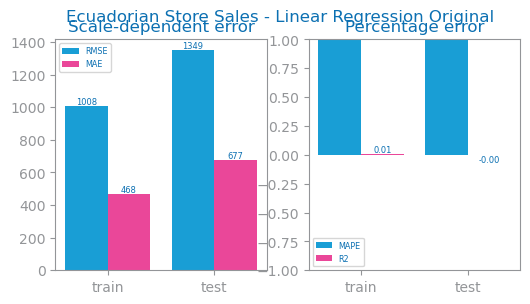

In [6]:
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import savefig
import pandas as pd
from numpy import arange

train, test = series_train_test_split(data, trn_pct=0.80)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(data)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression Original")

<Axes: xlabel='date', ylabel='sales'>

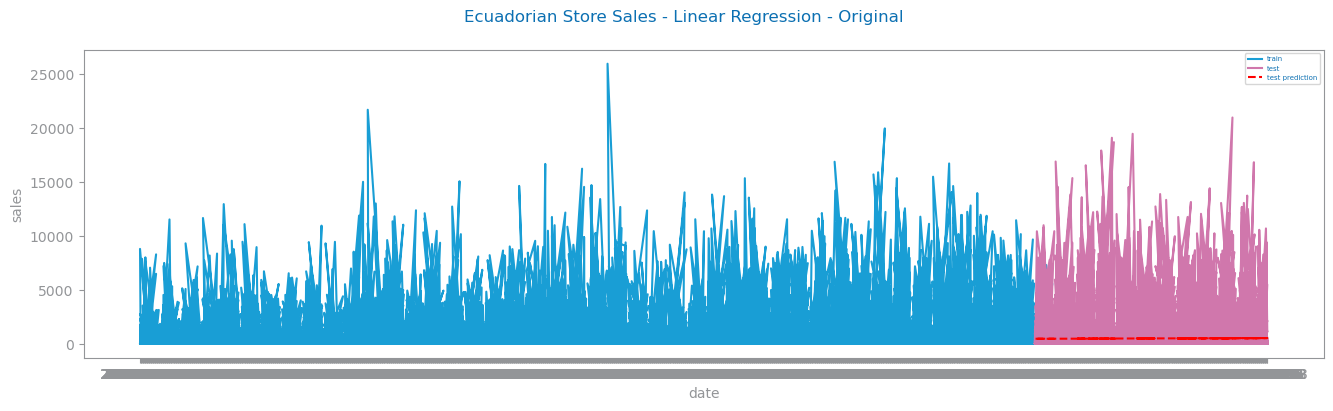

In [7]:
target = "sales"
series: Series = data[target]

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression - Original",
    xlabel="date",
    ylabel=target,
)

# Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

def scale_all_dataframe(data: DataFrame) -> DataFrame:
    vars: list[str] = data.columns.to_list()
    transf: StandardScaler = StandardScaler().fit(data)
    df = DataFrame(transf.transform(data), index=data.index)
    df.columns = vars
    return df

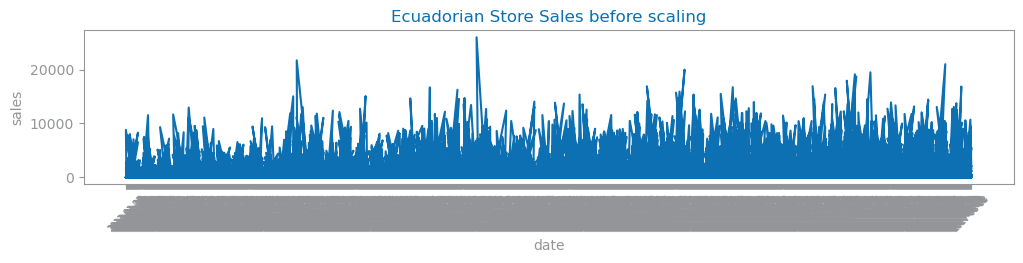

In [9]:
target = "sales"
series: Series = data[target]

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} before scaling",
)
show()

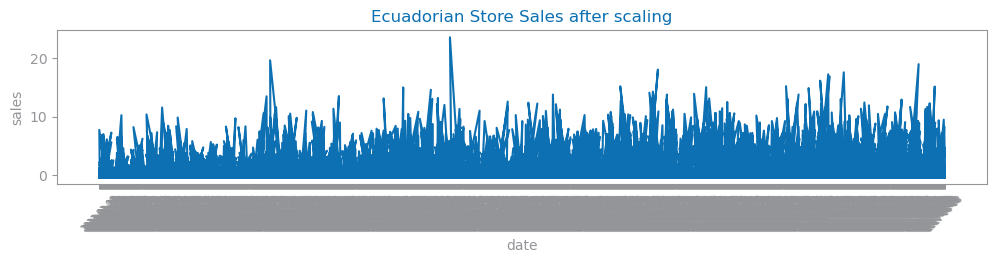

In [10]:
on_promotion_col = data["onpromotion"]

df_scaled = scale_all_dataframe(data.drop(columns=["onpromotion"], errors="ignore"))
df_scaled["onpromotion"] = on_promotion_col
series_scaled = df_scaled[[target, "onpromotion"]]

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_scaled.index.to_list(),  # Correct for index
    series_scaled[target].to_list(),  # Extract the target column as a list
    xlabel=series_scaled.index.name,
    ylabel=target,
    title=f"{file_tag} after scaling",
)
show()

## Evaluate

array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

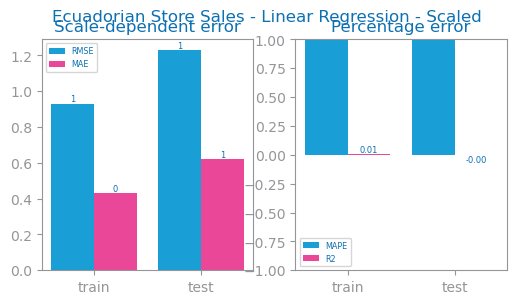

In [11]:
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import savefig
import pandas as pd
from numpy import arange
series_scaled = series_scaled.sort_index()

train, test = series_train_test_split(series_scaled, trn_pct=0.80)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(series_scaled)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression - Scaled")

<Axes: xlabel='date', ylabel='sales'>

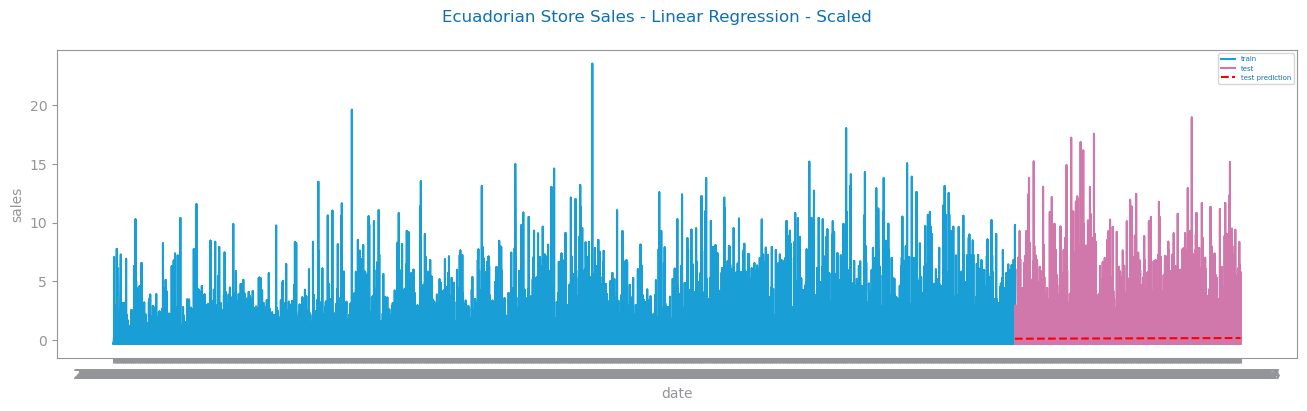

In [12]:
target = "sales"

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression - Scaled",
    xlabel="date",
    ylabel=target,
)

# Aggregation
Aggregation is just the operation of grouping smaller details into a coarser one, most similar to the approach we took in the profiling step.

In order to do it, we just need to apply the previous function - ts_aggregation_by, already available in the dslabs_functions file, that receives the univariate series to transform, the granularity level to aggregate into - gran_level, and the aggregation function to apply - agg_func.

In [13]:
def ts_aggregation_by(
    data: Series | DataFrame,
    gran_level: str = "D",
    agg_func: str = "mean",
) -> Series | DataFrame:
    # Make sure the index is a DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    
    df: Series | DataFrame = data.copy()
    index: Index[Period] = df.index.to_period(gran_level)  # Convert to PeriodIndex based on granularity
    df = df.groupby(by=index, dropna=True, sort=True).agg(agg_func)
    
    # Optional: Drop duplicates in the index if needed
    df.index = df.index.to_timestamp()  # Convert PeriodIndex back to DatetimeIndex
    
    return df


In [14]:
series_scaled.head()

,sales,onpromotion
date,,
2013-01-01,-0.328238,0
2013-01-01,-0.328238,0
2013-01-01,-0.328238,0
2013-01-01,-0.328238,0
2013-01-01,-0.328238,0


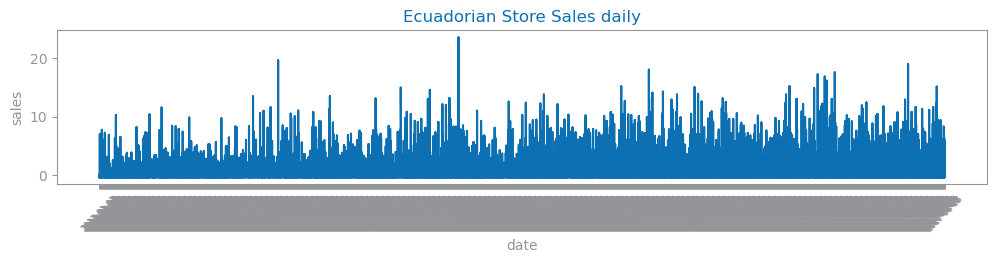

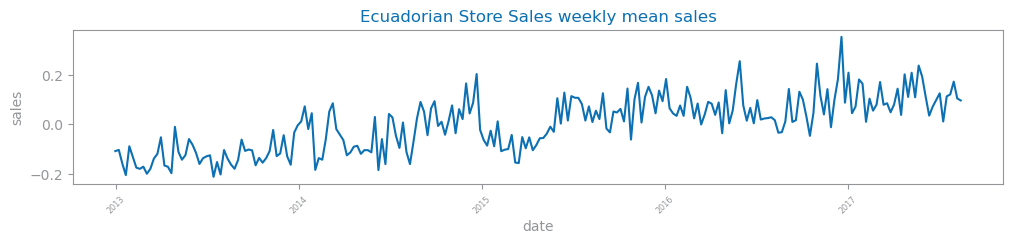

In [15]:
series: Series = data[target]
series_scaled = series_scaled.sort_index()
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_scaled.index.to_list(),
    series_scaled[target].to_list(),
    xlabel=series_scaled.index.name,
    ylabel=target,
    title=f"{file_tag} daily",
)

series_scaled_agg_w: Series = ts_aggregation_by(series_scaled, gran_level="w", agg_func="mean")
series_scaled_agg_w.index = pd.to_datetime(series_scaled_agg_w.index)

series_scaled_agg_d: Series = ts_aggregation_by(series_scaled, gran_level="d", agg_func="mean")
series_scaled_agg_d.index = pd.to_datetime(series_scaled_agg_d.index)

series_scaled_agg_m: Series = ts_aggregation_by(series_scaled, gran_level="m", agg_func="mean")
series_scaled_agg_m.index = pd.to_datetime(series_scaled_agg_m.index)

series_scaled_agg_q: Series = ts_aggregation_by(series_scaled, gran_level="q", agg_func="mean")
series_scaled_agg_q.index = pd.to_datetime(series_scaled_agg_q.index)

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series_scaled_agg_w.index.to_list(),
    series_scaled_agg_w[target].to_list(),
    xlabel=series_scaled_agg_w.index.name,
    ylabel=target,
    title=f"{file_tag} weekly mean {target}",
)
show()

## Evaluate 

In [16]:
series_scaled_agg_w.head()

,sales,onpromotion
date,,
2012-12-31,-0.107524,0.0
2013-01-07,-0.102713,0.0
2013-01-14,-0.157644,0.0
2013-01-21,-0.204250,0.0
2013-01-28,-0.087915,0.0


array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

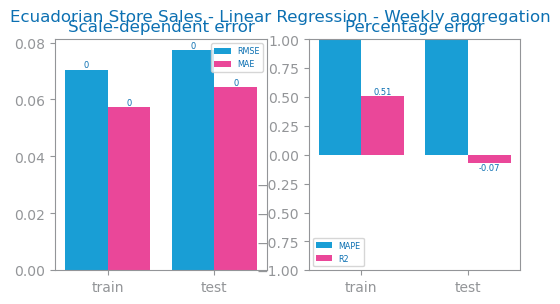

In [17]:
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import savefig
import pandas as pd
from numpy import arange
series_scaled_agg_w = series_scaled_agg_w.sort_index()

train, test = series_train_test_split(series_scaled_agg_w, trn_pct=0.80)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(series_scaled_agg_w)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression - Weekly aggregation")

<Axes: xlabel='date', ylabel='sales'>

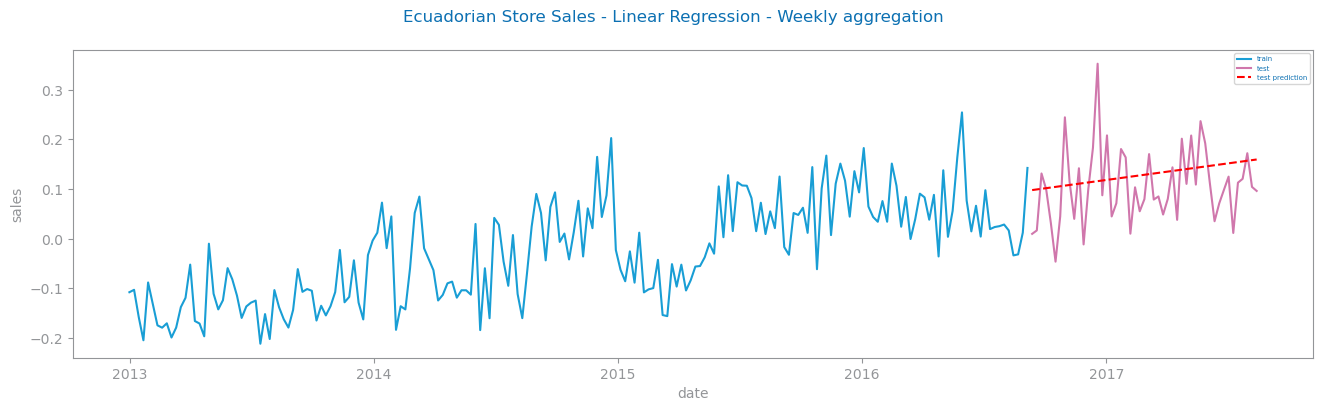

In [18]:
target = "sales"
series: Series = data[target]

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression - Weekly aggregation",
    xlabel="date",
    ylabel=target,
)

# Differentiation
- First differentiation removes trends (e.g., converts increasing values into stationary changes).
- Second differentiation removes linear trends (useful if first differentiation still shows patterns).
- Third differentiation is rare but can be used for very strong trends

i did with 1,2,3 and nothing changed in R2. 


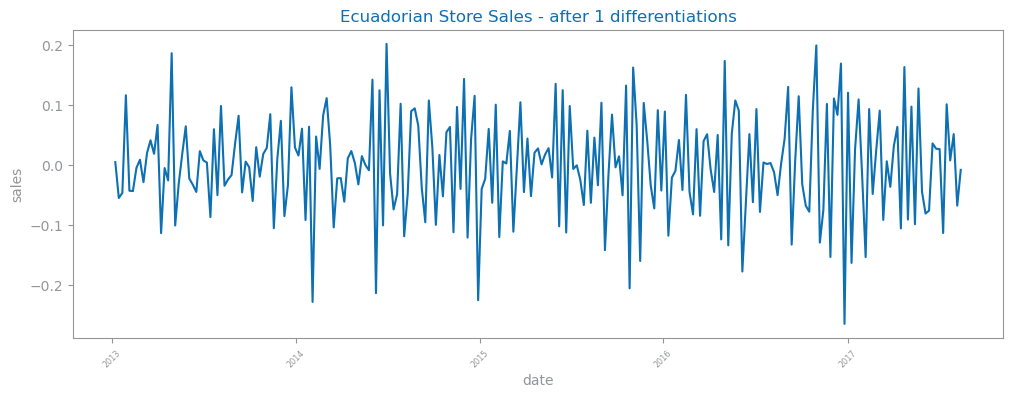

In [19]:
# Function to differentiate multiple times
def differentiate_series(series, n):
    for _ in range(n):
        series = series.diff().dropna()  # Differentiation and dropping NaNs
    return series

# Apply multiple differentiations
n_diff = 1  # Number of times to differentiate (e.g., 3 times)
series_scaled_diff = differentiate_series(series_scaled_agg_w, n_diff)

# Plot the result after differentiation
figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series_scaled_diff.index.to_list(),
    series_scaled_diff[target].to_list(),
    title=f"{file_tag} - after {n_diff} differentiations",
    xlabel=series_scaled_diff.index.name,
    ylabel=target,
)
show()

## Evaluate 

array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

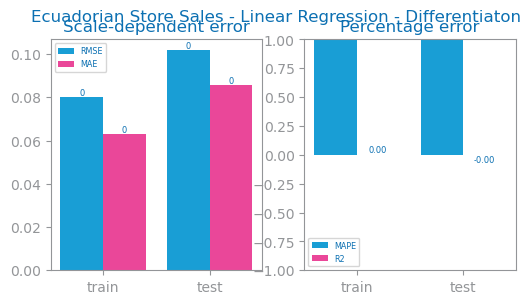

In [20]:
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import savefig
import pandas as pd
from numpy import arange
series_scaled_diff = series_scaled_diff.sort_index()
series_scaled_diff = series_scaled_diff.dropna()

train, test = series_train_test_split(series_scaled_diff, trn_pct=0.80)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(series_scaled_diff)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression - Differentiaton")

# Smoothing
Não aplicar no conjunto de teste

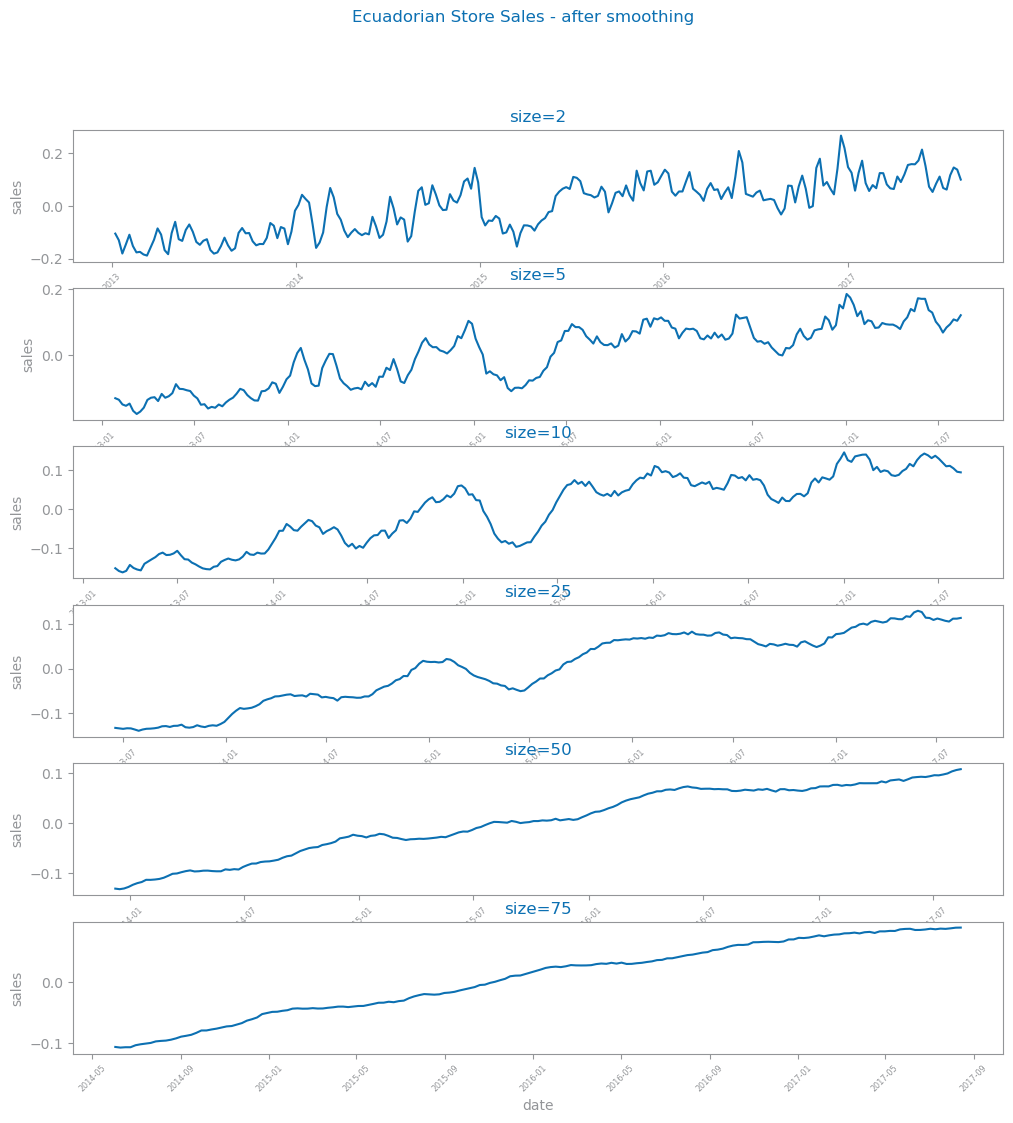

In [21]:
from matplotlib.pyplot import subplots
from matplotlib.axes import Axes
from matplotlib.figure import Figure

sizes: list[int] = [2, 5, 10, 25, 50, 75]
fig: Figure
axs: list[Axes]
fig, axs = subplots(len(sizes), 1, figsize=(3 * HEIGHT, HEIGHT / 2 * len(sizes)))
fig.suptitle(f"{file_tag} - after smoothing")

for i in range(len(sizes)):
    ss_smooth: Series = series_scaled_agg_w.rolling(window=sizes[i]).mean()
    plot_line_chart(
        ss_smooth.index.to_list(),
        ss_smooth[target].to_list(),
        ax=axs[i],
        xlabel=ss_smooth.index.name,
        ylabel=target,
        title=f"size={sizes[i]}",
    )
show()

## Evaluate

dont apply to test data!!!

Smoothing Size 2:
Train Length: 192, Train Predictions Length: 192
Test Length: 49, Test Predictions Length: 49
Smoothing Size 5:
Train Length: 189, Train Predictions Length: 189
Test Length: 49, Test Predictions Length: 49
Smoothing Size 15:
Train Length: 179, Train Predictions Length: 179
Test Length: 49, Test Predictions Length: 49
Smoothing Size 30:
Train Length: 164, Train Predictions Length: 164
Test Length: 49, Test Predictions Length: 49
Smoothing Size 55:
Train Length: 139, Train Predictions Length: 139
Test Length: 49, Test Predictions Length: 49
Smoothing Size 80:
Train Length: 114, Train Predictions Length: 114
Test Length: 49, Test Predictions Length: 49


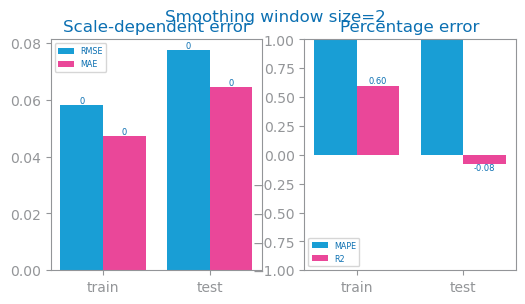

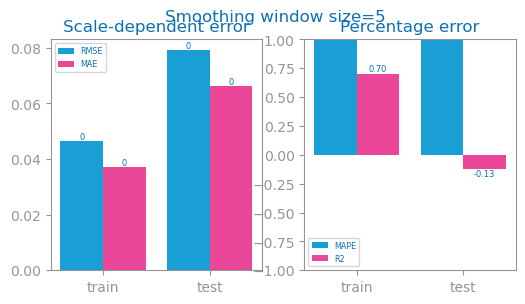

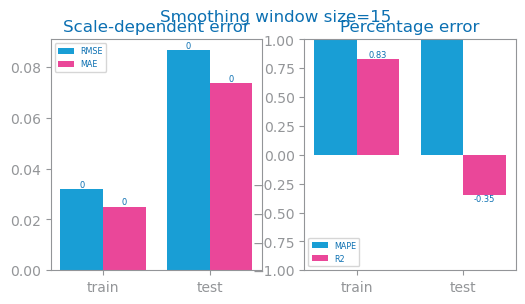

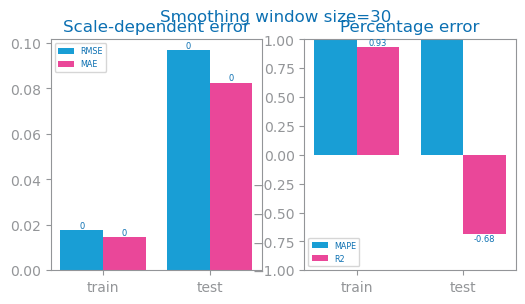

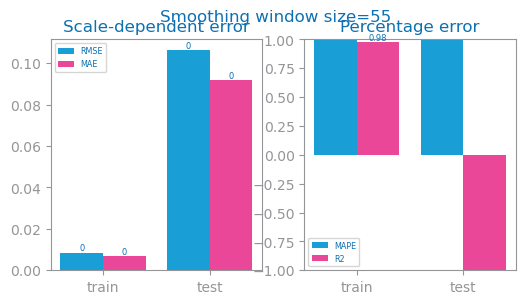

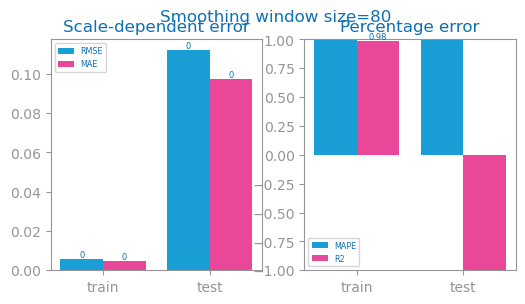

In [22]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

sizes: list[int] = [2, 5, 15, 30, 55, 80]

# Create a LinearRegression model
model = LinearRegression()

# Store evaluation metrics
ev1 = {"RMSE": [], "MAE": []}
ev2 = {"MAPE": [], "R2": []}

for size in sizes:
    # Split into train and test before applying smoothing
    train, test = series_train_test_split(series_scaled_agg_w, trn_pct=0.80)

    # Apply smoothing only to the train set
    train_smoothed = train.rolling(window=size).mean().dropna()

    # Align train_smoothed with its original index
    train_smoothed = train_smoothed.reindex(train.index)

    # Drop NaN values (moving average creates NaNs at the start)
    train_smoothed = train_smoothed.dropna()

    # Ensure test remains untouched
    tstX = np.arange(len(train), len(series_scaled_agg_w)).reshape(-1, 1)
    tstY = test.to_numpy()

    # Prepare training data (only valid non-NaN smoothed values)
    trnX = np.arange(len(train_smoothed)).reshape(-1, 1)
    trnY = train_smoothed.to_numpy()

    # Train the model
    model.fit(trnX, trnY)

    # Make predictions
    prd_trn = model.predict(trnX)
    prd_tst = model.predict(tstX)

    # **Align predictions to correct indices**
    prd_trn_series = pd.Series(prd_trn, index=train_smoothed.index)  # Matches train_smoothed
    prd_tst_series = pd.Series(prd_tst, index=test.index)  # Matches test

    # **Re-check lengths before passing to evaluation function**
    print(f"Smoothing Size {size}:")
    print(f"Train Length: {len(train_smoothed)}, Train Predictions Length: {len(prd_trn_series)}")
    print(f"Test Length: {len(test)}, Test Predictions Length: {len(prd_tst_series)}")

    # Evaluate performance
    plot_forecasting_eval(
        train_smoothed,  # Use smoothed train for evaluation
        test,            # Unchanged test data
        prd_trn_series, 
        prd_tst_series, 
        title=f"Smoothing window size={size}"
    )

# Show plots
show()


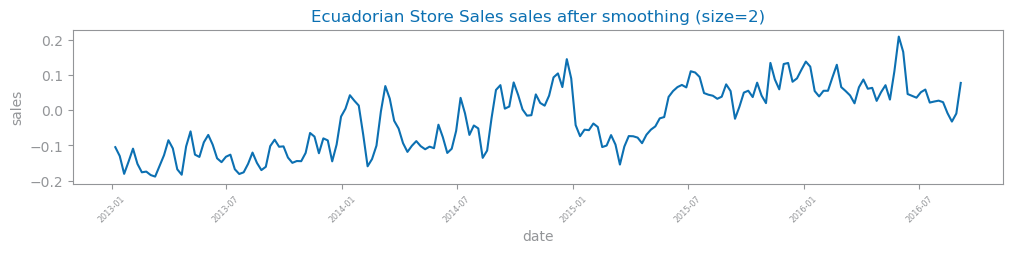

In [23]:
train, test = series_train_test_split(series_scaled_agg_w, trn_pct=0.80)

# Apply smoothing to train only
WIN_SIZE = 2
train_smoothed = train.rolling(window=WIN_SIZE).mean().dropna()

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    train_smoothed.index.to_list(),
    train_smoothed.to_list(),
    xlabel=train_smoothed.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after smoothing (size={WIN_SIZE})",
)
show()


# Save df from preprocessing into a csv file

In [24]:
series_scaled_agg_w.head()

,sales,onpromotion
date,,
2012-12-31,-0.107524,0.0
2013-01-07,-0.102713,0.0
2013-01-14,-0.157644,0.0
2013-01-21,-0.204250,0.0
2013-01-28,-0.087915,0.0


In [25]:
#data_copy=pd.read_csv(filepath)     
train_save, test_save = series_train_test_split_multiv(series_scaled_agg_w, trn_pct=0.80)

train_save.to_csv(f"dataset/series_scaled_agg_w_train_multi.csv", index=True)

test_save.to_csv(f"dataset/series_scaled_agg_w_test_multi.csv", index=True)
    
train_save.head()


,sales,onpromotion
date,,
2012-12-31,-0.107524,0.0
2013-01-07,-0.102713,0.0
2013-01-14,-0.157644,0.0
2013-01-21,-0.204250,0.0
2013-01-28,-0.087915,0.0


In [26]:
test_save.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2016-09-12 to 2017-08-14
Freq: W-MON
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sales        49 non-null     float64
 1   onpromotion  49 non-null     float64
dtypes: float64(2)
memory usage: 1.1 KB
